In [5]:
import numpy as np
from matplotlib import pyplot
import chaospy as cp 

from scipy.io import loadmat
import spgl1 as spg

In [51]:
## Inputs - load and format
 
uniform_data = loadmat('Diffuser_data_0/uniform_mat.mat')
uniform_data = uniform_data['uniform_mat'].T

samples = uniform_data[:,:]

# Stochastic dimension (number of variables sampled)
d = samples.shape[0]
# Number of samples - originally 500 but 5 runs that diverged have been removed 
n_samp = samples.shape[1]

# Evaluations - recirculation length
evaluations = loadmat('Diffuser_data_0/data_diffuser.mat')
#evaluations = evaluations['data_diffuser']
evaluations = np.reshape(evaluations['data_diffuser'], -1)


print(samples.shape)
print(evaluations.shape)
samples[:,0:2]

(5, 495)
(495,)


array([[ 0.47053404,  0.22257798],
       [-0.09446919,  0.68218687],
       [ 0.6721462 , -0.04786531],
       [-0.19492023,  0.81100996],
       [-0.04073492,  0.95030637]])

In [13]:
## Set up distribtion

distribution_uniform = cp.Uniform(-1,1)
# We sample all 5 parameters as uniform distribution
distribution = cp.Iid(distribution_uniform,d)
distribution

Iid(Uniform(lower=-1, upper=1), 5)

In [29]:
# Choose polynomial order - calibrate this for minimum validation error
polynomial_order = 4

# Construct PC expansion 
polynomial_expansion = cp.orth_ttr(
    polynomial_order, distribution)


In [40]:
## Fit pc expansion to data. Chaospy default is least squares.
model_approximation_cp = cp.fit_regression(polynomial_expansion, samples[:,0:400], evaluations[0:400])
# While this gives an estimate of the data, really we want the pc coefficients which we can use to compute validation error

In [41]:
# Calculate PC coefficients and compute validation error
phi = polynomial_expansion(*samples[:,0:400]).T
ptp = phi.T @ phi
pty = phi.T @ evaluations[0:400]
c_hat = np.linalg.inv(ptp) @ pty
print(c_hat.shape)

# validation error
phi_val = polynomial_expansion(*samples[:,400:]).T
val_est = phi_val @ c_hat
print(val_est.shape)
val_error = np.linalg.norm(evaluations[400:] - val_est)/np.linalg.norm(evaluations[400:])
print(val_error)

(126,)
(95,)
0.1082381514906898


In [42]:
# Calculate PC coefficients and compute validation error with an alternative solver, i.e., spgl1 bpdn. 
# for some problems this may be advantageous 
phi = polynomial_expansion(*samples[:,0:400]).T

sigma = 0.001
c_hat_spg, resid, grad, info  = spg.spg_bpdn(phi, evaluations[0:400], sigma)
print(c_hat_spg.shape)

# validation error
phi_val = polynomial_expansion(*samples[:,400:]).T
val_est = phi_val @ c_hat_spg
print(val_est.shape)
val_error = np.linalg.norm(evaluations[400:] - val_est)/np.linalg.norm(evaluations[400:])
print(val_error)

(400, 126)
(400,)
(126,)
(95,)
0.1082380328586923


In [49]:
## Calculate sobol indices from pc exansion 
model_approximation = np.sum(c_hat_spg*polynomial_expansion)
print(model_approximation_2.shape)

# First order sobol indice
s_1 = cp.Sens_m(model_approximation, distribution)
# Total sobol indice
s_t = cp.Sens_t(model_approximation, distribution)

s_interactions = s_t-s_1
print(s_t)
print(s_t.shape)


()
[0.61124586 0.2453018  0.18647151 0.0669517  0.39429667]
(5,)


[0.26617975 0.18139497 0.16698187 0.05952215 0.22703901]
0.8693295472776954


array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

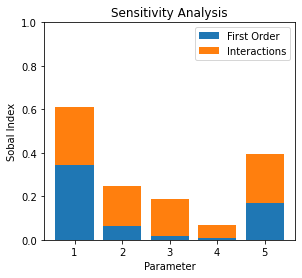

In [50]:
## Plot sensitivity 

# Python plot a stacked histogram
pyplot.rc("figure", figsize=[4.5, 4])

## Show samples as 2-dimensional scatter plot
##pyplot.scatter(*samples[rule], marker="x", color="k")

p1 = pyplot.bar([1,2,3,4,5], np.ravel(s_1))
p2 = pyplot.bar([1,2,3,4,5], np.ravel(s_t-s_1), bottom=np.ravel(s_1))

## Make scatter ficutres pretty
pyplot.xlabel("Parameter")
pyplot.xticks([1,2,3,4,5], ('1', '2', '3', '4', '5'))
pyplot.ylabel("Sobal Index") 
pyplot.yticks(np.arange(0, 1.1, 0.2))
pyplot.legend((p1[0], p2[0]), ('First Order', 'Interactions'))
pyplot.title("Sensitivity Analysis")

##pyplot.axis([0.9, 2.1, 0.1, 0.2])
np.arange(0, 1.1, 0.2)